[*********************100%%**********************]  1 of 1 completed
/var/folders/fz/8cgrbwx93qg5htlktqxm78k00000gn/T/ipykernel_8764/3587776508.py:21: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  data['Signal'][self.short_window:] = np.wher

Cumulative Returns: 2.84
Annualized Returns: 0.18
Sharpe Ratio: 0.80
Max Drawdown: -0.42
Calmar Ratio: 0.43
Sortino Ratio: 0.89

YoY Growth:
Year
2015          NaN
2016     7.503472
2017    46.080160
2018    -7.323550
2019    44.602676
2020    80.555742
2021    33.779109
2022   -24.453091
Name: Portfolio Value, dtype: float64


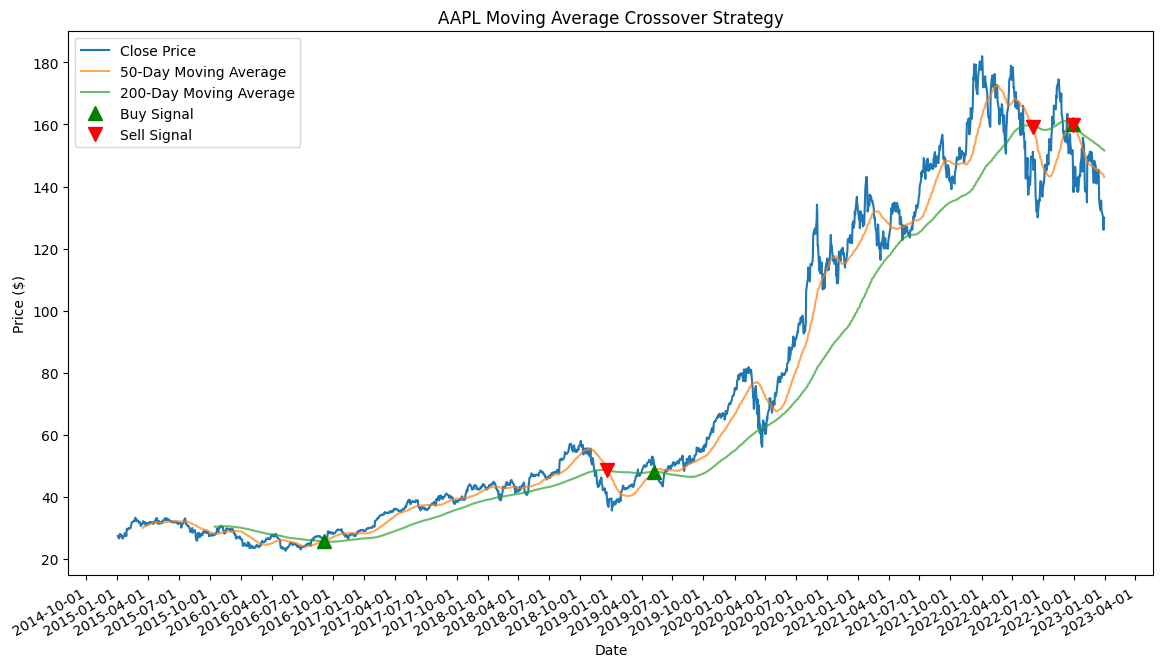

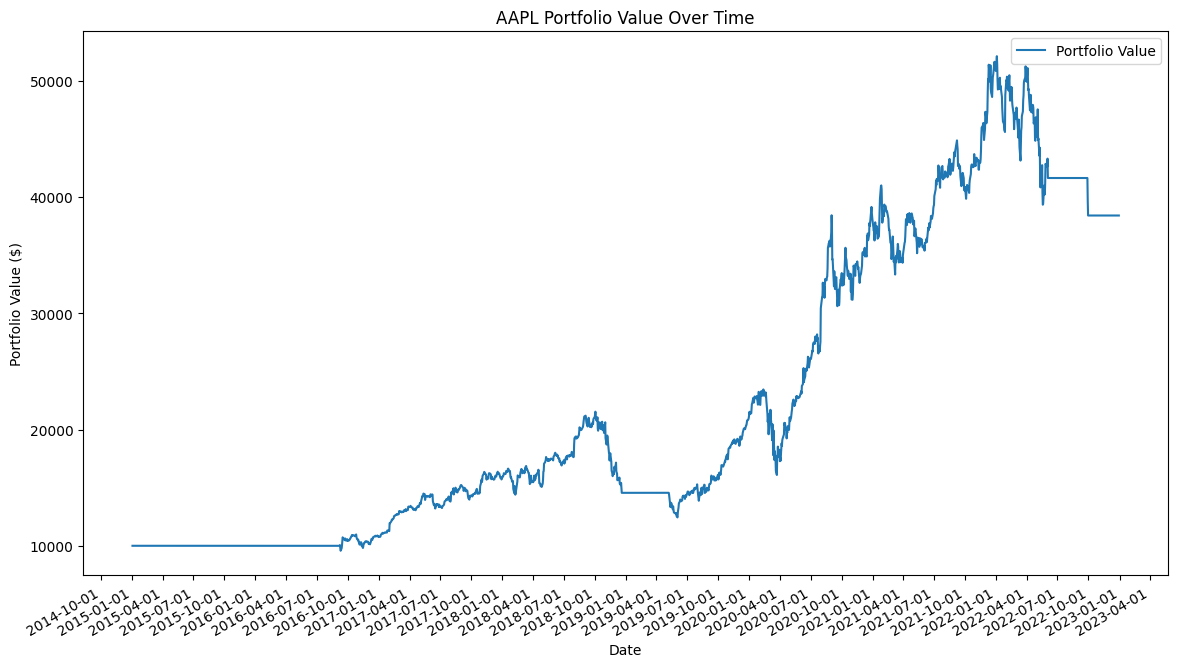

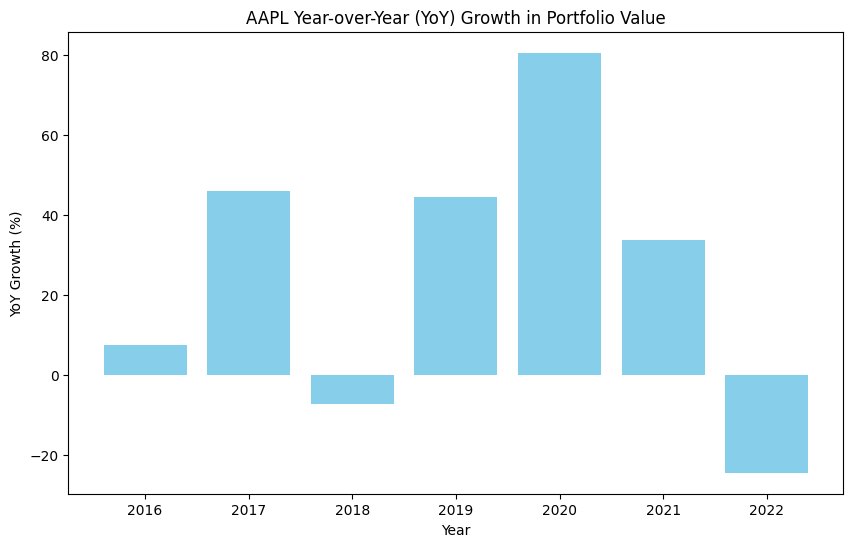

In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# 1. Data Download Function
def download_data(ticker, start_date, end_date):
    return yf.download(ticker, start=start_date, end=end_date)

# 2. Strategy Class
class MovingAverageCrossoverStrategy:
    def __init__(self, short_window=50, long_window=200):
        self.short_window = short_window
        self.long_window = long_window

    def generate_signals(self, data):
        data['Short_MA'] = data['Close'].rolling(window=self.short_window).mean()
        data['Long_MA'] = data['Close'].rolling(window=self.long_window).mean()
        data['Signal'] = 0
        data['Signal'][self.short_window:] = np.where(
            data['Short_MA'][self.short_window:] > data['Long_MA'][self.short_window:], 1, 0)
        data['Position'] = data['Signal'].diff()
        return data

# 3. Backtesting Class
class Backtester:
    def __init__(self, initial_capital=10000.0):
        self.initial_capital = initial_capital

    def run_backtest(self, data):
        cash = self.initial_capital
        shares_held = 0
        portfolio_value = []

        for i in range(len(data)):
            if data['Position'].iloc[i] == 1:  # Buy signal
                shares_held = cash // data['Close'].iloc[i]
                cash -= shares_held * data['Close'].iloc[i]
            elif data['Position'].iloc[i] == -1:  # Sell signal
                cash += shares_held * data['Close'].iloc[i]
                shares_held = 0

            portfolio_value.append(cash + shares_held * data['Close'].iloc[i])

        data['Portfolio Value'] = portfolio_value
        return data

# 4. Performance Metrics Class
class PerformanceMetrics:
    @staticmethod
    def calculate_metrics(data, initial_capital):
        cumulative_returns = (data['Portfolio Value'].iloc[-1] / initial_capital) - 1
        annualized_return = (1 + cumulative_returns) ** (252 / len(data)) - 1
        sharpe_ratio = (data['Portfolio Value'].pct_change().mean() / data['Portfolio Value'].pct_change().std()) * np.sqrt(252)

        data['Year'] = data.index.year
        yoy_growth = data.groupby('Year')['Portfolio Value'].last().pct_change() * 100

        data['Cumulative Max'] = data['Portfolio Value'].cummax()
        data['Drawdown'] = data['Portfolio Value'] / data['Cumulative Max'] - 1
        max_drawdown = data['Drawdown'].min()

        calmar_ratio = annualized_return / abs(max_drawdown)

        downside_returns = data['Portfolio Value'].pct_change()[data['Portfolio Value'].pct_change() < 0]
        sortino_ratio = data['Portfolio Value'].pct_change().mean() / downside_returns.std() * np.sqrt(252)

        return {
            'Cumulative Returns': cumulative_returns,
            'Annualized Returns': annualized_return,
            'Sharpe Ratio': sharpe_ratio,
            'Max Drawdown': max_drawdown,
            'Calmar Ratio': calmar_ratio,
            'Sortino Ratio': sortino_ratio,
            'YoY Growth': yoy_growth
        }

# 5. Visualization Functions
def plot_signals(data, ticker):
    plt.figure(figsize=(14, 8))
    plt.plot(data.index, data['Close'], label='Close Price')
    plt.plot(data.index, data['Short_MA'], label='50-Day Moving Average', alpha=0.7)
    plt.plot(data.index, data['Long_MA'], label='200-Day Moving Average', alpha=0.7)
    plt.plot(data[data['Position'] == 1].index, data['Short_MA'][data['Position'] == 1], '^', markersize=10, color='g', lw=0, label='Buy Signal')
    plt.plot(data[data['Position'] == -1].index, data['Short_MA'][data['Position'] == -1], 'v', markersize=10, color='r', lw=0, label='Sell Signal')

    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=3))
    plt.gcf().autofmt_xdate()

    plt.title(f'{ticker} Moving Average Crossover Strategy')
    plt.xlabel('Date')
    plt.ylabel('Price ($)')
    plt.legend()
    plt.show()

def plot_portfolio_value(data, ticker):
    plt.figure(figsize=(14, 8))
    plt.plot(data.index, data['Portfolio Value'], label='Portfolio Value')
    plt.title(f'{ticker} Portfolio Value Over Time')
    plt.xlabel('Date')
    plt.ylabel('Portfolio Value ($)')
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=3))
    plt.gcf().autofmt_xdate()
    plt.legend()
    plt.show()

def plot_yoy_growth(yoy_growth, ticker):
    plt.figure(figsize=(10, 6))
    plt.bar(yoy_growth.index[1:], yoy_growth[1:], color='skyblue')
    plt.title(f'{ticker} Year-over-Year (YoY) Growth in Portfolio Value')
    plt.xlabel('Year')
    plt.ylabel('YoY Growth (%)')
    plt.show()

# 6. Main Function
def main():
    # Parameters
    ticker = 'AAPL'
    start_date = '2015-01-01'
    end_date = '2023-01-01'
    initial_capital = 10000.0

    # Download data
    data = download_data(ticker, start_date, end_date)

    # Initialize strategy and generate signals
    strategy = MovingAverageCrossoverStrategy(short_window=50, long_window=200)
    data = strategy.generate_signals(data)

    # Backtest the strategy
    backtester = Backtester(initial_capital=initial_capital)
    data = backtester.run_backtest(data)

    # Calculate performance metrics
    metrics = PerformanceMetrics.calculate_metrics(data, initial_capital)
    for key, value in metrics.items():
        if isinstance(value, pd.Series):
            print(f"\n{key}:\n{value}")
        else:
            print(f"{key}: {value:.2f}")

    # Plot results
    plot_signals(data, ticker)
    plot_portfolio_value(data, ticker)
    plot_yoy_growth(metrics['YoY Growth'], ticker)

# Run the main function
if __name__ == "__main__":
    main()
